### 导入所需要的包

In [1]:
import sys
import os

# 添加 src 到路径, 便于导入
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "../src")))

%matplotlib widget
import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon, LineString, box
import math
import numpy as np
import re
from rich import print

# 自定义模块导入
from display_class import *
from CADAlgo.check import *
from CADAlgo.generate import *
from CADAlgo.parser import *

In [2]:
def test_from_json(path: str):
    with open(path, "r", encoding="utf-8") as f:
        final_result_dict = json.load(f)
    schema = parse_schema(final_result_dict)
    _, _ = plot_schema(schema)
    line_candidate: list[LineString] = []
    for my_line in schema.line_candidates[:]:
        for l in my_line.lines:
            line_candidate.append(l.geometry)

    point_candidates = schema.point_candidates
    line_candidates = schema.line_candidates
    exterior = schema.target_exterior
    obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
    samples_distance = 3
    lines = generate_connection_lines_from_point_candidates_backtracking(
        point_candidates, line_candidates, exterior, obstacles,dispel_lines=[], samples_distance=samples_distance
    )

    fig, ax = plot_schema(schema)

    # 连接线
    for line in lines:
        x_line, y_line = line.xy
        ax.plot(x_line, y_line, color="magenta", linewidth=1.5)

    print(f"Total parts: {len(schema.point_candidates)+len(schema.line_candidates)}")

In [ ]:
test_from_json(os.path.join("生成参数", "_N02正视图.json"))

In [ ]:
test_from_json(os.path.join("生成参数", "_N03正视图.json"))

In [ ]:
test_from_json(os.path.join("生成参数", "_N04正视图.json"))

In [ ]:
test_from_json(os.path.join("生成参数","_N05正视图.json"))

In [ ]:
test_from_json(os.path.join("生成参数", "_N11正视图.json"))

下面是带优先级的效果

In [ ]:
test_from_json(os.path.join("real_data", "N04-成品图-主视图_schema.json"))

In [ ]:
test_from_json(os.path.join("real_data", "N12-成品图-主视图_schema.json"))

Total parts: 5

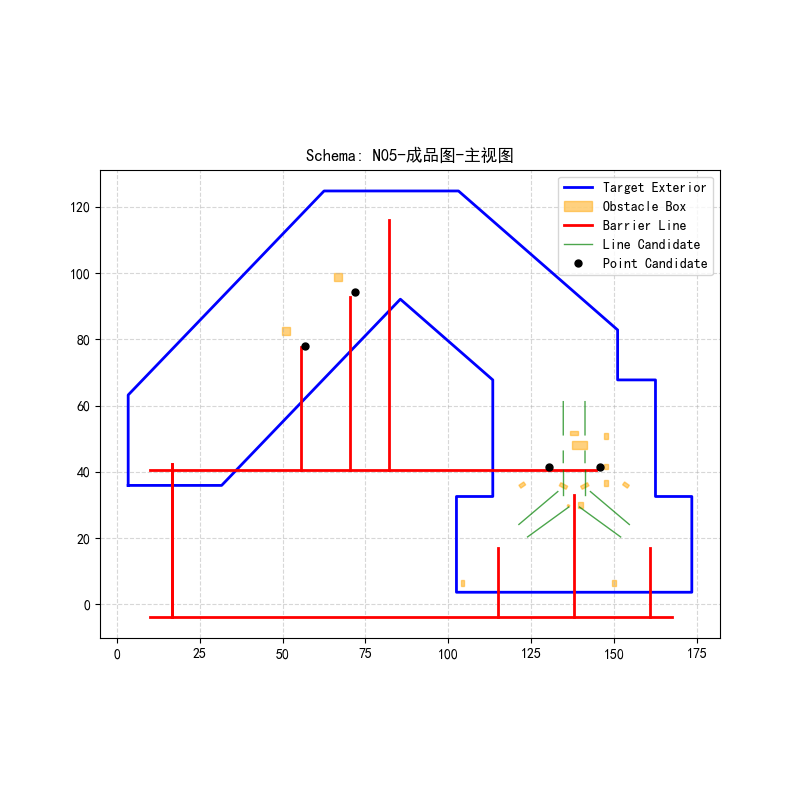

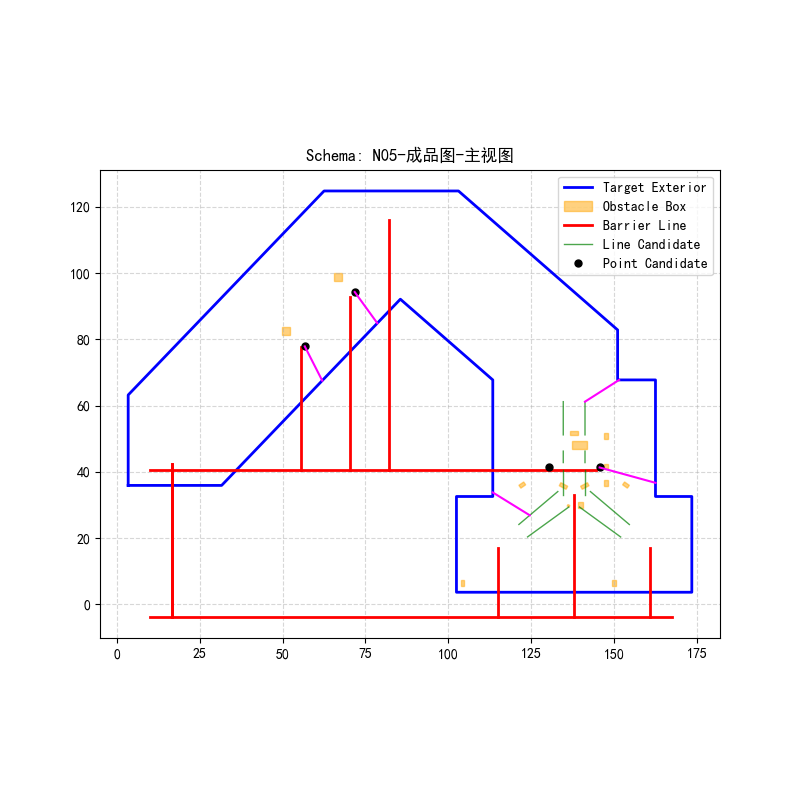

In [3]:
test_from_json(os.path.join("real_data", "N05-成品图-主视图_schema.json"))

Total parts: 2

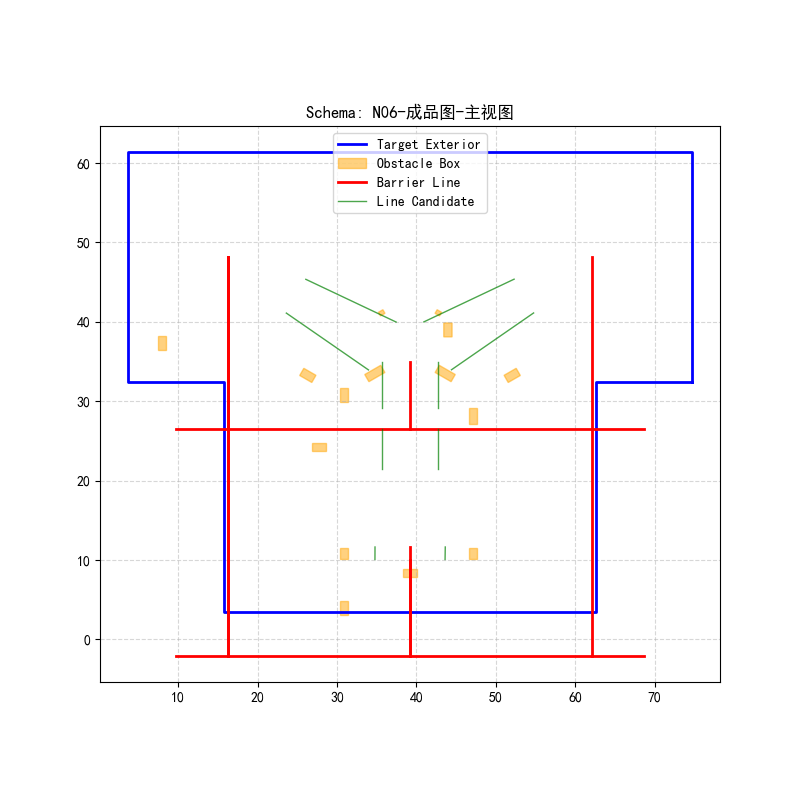

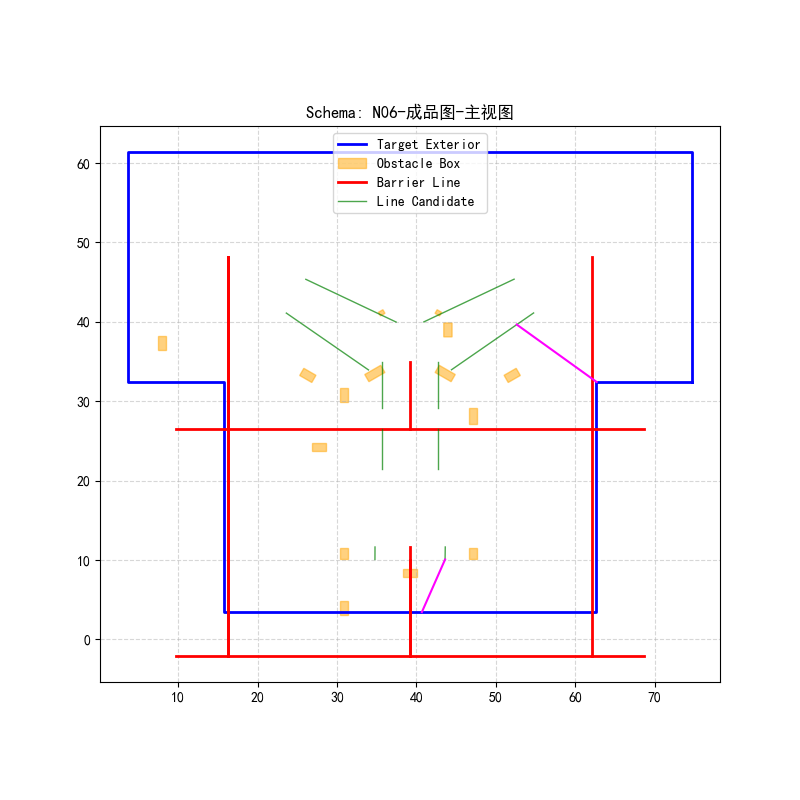

In [4]:
test_from_json(os.path.join("real_data", "N06-成品图-主视图_schema.json"))